In [5]:
import numpy as np
import scipy as sc
import scipy.linalg as scl
from dncon import dncon
import matplotlib.pyplot as plt

# ncon (Contract diagram)

Given a number of tensors connected in a diagram, specify the legs of each tensor with a label and output the contraction of the diagram.
The labeling is done as 1,2,3,... for the connected legs that are going to be contracted and in the order of contraction. The open legs are labeled as -1, -2, -3, ..., representing the order in which they will be represented in the output tensor.

In [7]:
def ncon(tensorlist,labellist):
    maxlabel = max(max(labellist)) 
    label = 1

    while label <= maxlabel:
        tensor1_found = False
        tensor2_found = False
        #Find the tensors that have the label for the leg that is going to be contracted next
        for ten_ind in range(len(labellist)):
            for i in range(len(labellist[ten_ind])):
                if labellist[ten_ind][i] == label:
                    #if a leg connect a tensor with itself, tensor1 and tensor2 are the same
                    if labellist[ten_ind].count(label) == 2:
                        labels = [label]
                        tensor1 = tensorlist[ten_ind]
                        tensor1_number = ten_ind
                        tensor1_index_con = [i]
                        tensor1_found = True
                        for j in range(i+1,len(labellist[ten_ind])):
                            if labellist[ten_ind][j] == label:
                                tensor2 = tensorlist[ten_ind]
                                tensor2_number = ten_ind
                                tensor2_index_con = [j]
                                tensor2_found = True
                                break
                        break
                    #if the labels connect different tensors, tensor1 and tensor2 are not the same
                    else:
                        if not tensor1_found:
                            tensor1 = tensorlist[ten_ind]
                            tensor1_number = ten_ind
                            tensor1_index_con = [i]
                            tensor1_found = True
                        else:
                            tensor2 = tensorlist[ten_ind]
                            tensor2_number = ten_ind
                            tensor2_index_con = [i]
                            tensor2_found = True
                        labels = [label]
                        #look if next label to contract is in the two chosen tensors, if it is, add it to the labels to contract
                        #keep looking until the condition is not met
                        look_for_more_contrac = True
                        while look_for_more_contrac and tensor2_found:
                            if label+1 in labellist[tensor1_number] and label+1 in labellist[tensor2_number]:
                                tensor1_index_con.append(labellist[tensor1_number].index(label+1))
                                tensor2_index_con.append(labellist[tensor2_number].index(label+1))
                                labels.append(label+1)
                                label += 1
                            else:
                                look_for_more_contrac = False
                        if tensor2_found:
                            break
            if tensor2_found:
                break
        
        #contract the two tensors in the indexes found if they are not the same tensor
        if tensor1_number != tensor2_number:
            tensor_contraction = np.tensordot(tensor1,tensor2,axes=(tensor1_index_con,tensor2_index_con))
            #update tensorlist so that the two just contracted tensors do not appear anymore
            tensorlist = tensorlist[:tensor1_number] + tensorlist[tensor1_number+1:tensor2_number] + tensorlist[tensor2_number+1:]
            
        #perfom a trace over the given indices if the labels belonged to the same tensor
        else:
            tensor_contraction = np.trace(tensor1,axis1=tensor1_index_con[0],axis2=tensor2_index_con[0])
            #update tensorlist so that the tensor does not appear anymore (traced version to be added back soon)
            tensorlist = tensorlist[:tensor1_number] + tensorlist[tensor1_number+1:]
            
        #construct the leg labels for the new tensor resulting from the contraction
        A = []
        for lab in labellist[tensor1_number]:
            if lab not in labels:
                A.append(lab)        
        labellist[tensor1_number] = A[:]
        if tensor1_number != tensor2_number:
            B = []
            for lab in labellist[tensor2_number]:
                if lab not in labels:
                    B.append(lab) 
            labellist[tensor2_number] = B[:]
        
            new_tensor_labels = labellist[tensor1_number] + labellist[tensor2_number]            
            labellist = labellist[:tensor1_number] + labellist[tensor1_number+1:tensor2_number] + labellist[tensor2_number+1:]

            
        else:
            new_tensor_labels = labellist[tensor1_number]
            labellist = labellist[:tensor1_number] + labellist[tensor1_number+1:]

        #add the resulting tensor and its labels to the begining of tensorlist and labellist
        tensorlist.insert(0, tensor_contraction)
        labellist.insert(0, new_tensor_labels)
        
        label += 1
    
    contracted_tensor = tensorlist[0]
    indices = labellist[0]
    
    #order the tensor indices so that they appear according to the -1,-2-3,... order
    indices = [-i for i in indices]
    
    open_leg_order = []
    for i in range(1,len(indices)+1):
        for j in range(len(indices)):
            if i == indices[j]:
                open_leg_order.append(j)
    
    contracted_tensor = np.transpose(contracted_tensor,open_leg_order)
        
    return contracted_tensor
        
        

In [11]:
A = np.random.random([6,6,6])
B = np.random.random([6,6,6])
C = np.random.random([6,6,6])
D = np.random.random([6,6,6])
F = ncon([A,B,C,D],[[4,1,5],[1,3,6],[5,3,2],[6,4,2]])
G = dncon([A,B,C,D],[[4,1,5],[1,3,6],[5,3,2],[6,4,2]])
print F, G

3153.76991647 3153.76991647


In [12]:
C = np.random.random([4,4])
T = np.random.random([4,4,2])
a = np.random.random([2,2,2,2])
B = ncon([C, T, T, a],[[1,2], [1,-1,3], [2,-3,4], [-2,3,4,-4]])
print(B.shape)

(4, 2, 4, 2)


In [13]:
A = np.random.random([5,6])
B = np.random.random([2,5])
C = np.random.random([2,7])
D = np.random.random([6,7])
F = ncon([A,B,C,D],[[1,3],[4,1],[4,2],[3,2]])
print F

12.6284158751


# tensorsvd

Routine for doing an SVD on a tensor by first permuting and reshaping into a matrix, then doing an SVD of this matrix with or without truncation and then reshaping back into tensors U, s, V

In [8]:
def tensorsvd(T_input,leftlegs,rightlegs,D='infinity'):
    T = np.transpose(T_input,leftlegs+rightlegs)
    xsize = 1
    leftsize_register = []
    for i in range(len(leftlegs)):
        xsize *= T.shape[i]
        leftsize_register.append(T.shape[i])
    ysize = 1
    rightsize_register = []
    for i in range(len(leftlegs),len(leftlegs)+len(rightlegs)):
        ysize *= T.shape[i]
        rightsize_register.append(T.shape[i])
    T = np.reshape(T,(xsize,ysize))
    
    U, s, V = np.linalg.svd(T,full_matrices = False)
    
    if D != 'infinity' and D < len(s):
        s = np.diag(s[:D])
        U = U[:,:D]
        V = V[:D,:]
    else:
        D = len(s)
        s = np.diag(s)
        
    U = np.reshape(U,leftsize_register+[D])
    V = np.reshape(V,[D]+rightsize_register)
        
        
    return U, s, V

In [15]:
A = np.random.random([3,4,5,8,4])

U, s, V = tensorsvd(A,[0,1,4],[2,3],D=10)

In [16]:
print U.shape
print s.shape
print V.shape

(3, 4, 4, 10)
(10, 10)
(10, 5, 8)


In [17]:
A_new = ncon([U,s,V],[[-1,-2,-5,1],[1,2],[2,-3,-4]])

In [18]:
print A.shape
print A_new.shape

(3, 4, 5, 8, 4)
(3, 4, 5, 8, 4)


# isingtpf2d (ising tensor partition fucntion 2D)

In [5]:
def isingtpf2d(beta,h):
    H_local = np.array([[-1.-h/2,1.],[1.,-1.+h/2]]) #h is intended to be a small magnetic field to break symmetry
    Q = np.exp(-beta*H_local)
    
    delta = np.zeros((2,2,2,2))
    delta[0,0,0,0] = 1.
    delta[1,1,1,1] = 1.

    Qsr = scl.sqrtm(Q)

    a = ncon([delta,Qsr,Qsr,Qsr,Qsr],[[1,2,3,4],[-1,1],[-2,2],[3,-3],[4,-4]])
    
    return a

a = isingtpf2d(1,0.005)
print a.shape
print a

(2, 2, 2, 2)
[[[[ 7.3582562   0.50187525]
   [ 0.50187525  0.06766775]]

  [[ 0.50187525  0.06766775]
   [ 0.06766775  0.49813102]]]


 [[[ 0.50187525  0.06766775]
   [ 0.06766775  0.49813102]]

  [[ 0.06766775  0.49813102]
   [ 0.49813102  7.28470523]]]]


In [20]:
def contraction_y(T,M,D='infinity'):
    '''
    Contraction of two rank 4 tensors along the vertical axis where T lies above M
    Outputs a rank 4 tensor obtained after contracting and performing HOSVD
    '''
    TM = ncon([T,M],[[-2,-3,-4,1],[-1,1,-5,-6]])
    U, s, V = tensorsvd(TM,[0,1],[2,3,4,5],D)
    
    TMsvd = ncon([U,TM,U],[[1,2,-1],[1,2,-2,3,4,-4],[3,4,-3]])   
    
    TMsvd = TMsvd/np.max(TMsvd) #divides over largest value in the tensor
        
    return TMsvd
    
def contraction_x(T,M,D='infinity'):
    '''
    Contraction of two rank 4 tensors along the horizontal axis where T lies left of M
    Outputs a rank 4 tensor obtained after contracting and performing HOSVD
    '''
    TM = ncon([T,M],[[-1,-2,1,-6],[1,-3,-4,-5]])
    U, s, V = tensorsvd(TM,[1,2],[0,3,4,5],D)

    TMsvd = ncon([U,TM,U],[[1,2,-2],[-1,1,2,-3,4,3],[3,4,-4]])   
    
    TMsvd = TMsvd/np.max(TMsvd) #divides over largest value in the tensor
        
    return TMsvd

In [21]:
print contraction_y(a,a).shape
print contraction_x(a,a).shape

(4, 2, 4, 2)
(2, 4, 2, 4)


In [22]:
a_ycont = contraction_y(a,a)

a_cont = contraction_x(a_ycont,a_ycont)

In [22]:
def coarse_graining_step(b,a,D='infinity'):
    
    A = ncon([a,a],[[-2,-3,-4,1],[-1,1,-5,-6]])
    U, s, V = tensorsvd(A,[0,1],[2,3,4,5],D)    
    A = ncon([U,A,U],[[1,2,-1],[1,2,-2,3,4,-4],[3,4,-3]])
    
    B = ncon([b,a],[[-2,-3,-4,1],[-1,1,-5,-6]])    
    B = ncon([U,B,U],[[1,2,-1],[1,2,-2,3,4,-4],[3,4,-3]])
    
    AA = ncon([A,A],[[-1,-2,1,-6],[1,-3,-4,-5]])
    U, s, V = tensorsvd(AA,[1,2],[0,3,4,5],D)  
    AA = ncon([U,AA,U],[[1,2,-2],[-1,1,2,-3,4,3],[3,4,-4]])  
    
    BA = ncon([B,A],[[-1,-2,1,-6],[1,-3,-4,-5]])
    BA = ncon([U,BA,U],[[1,2,-2],[-1,1,2,-3,4,3],[3,4,-4]])  
    
    BA = BA/np.max(AA) #divides over largest value in the tensor
    AA = AA/np.max(AA)
        
    return BA, AA


In [96]:
print ncon([a,a,a,a],[[7,5,3,1],[3,6,7,2],[8,1,4,5],[4,2,8,6]])
print dncon([a,a,a,a],[[7,5,3,1],[3,6,7,2],[8,1,4,5],[4,2,8,6]])

1.00000124279
1.00000124279


In [9]:
def isings2d(beta,h):
    H_local = np.array([[-1.-h/2,1.],[1.,-1.+h/2]])
    Q = np.exp(-beta*H_local)
    
    g = np.zeros((2,2,2,2))
    g[0,0,0,0] = 1.
    g[1,1,1,1] = -1.

    Qsr = scl.sqrtm(Q)

    b = ncon([g,Qsr,Qsr,Qsr,Qsr],[[1,2,3,4],[-1,1],[-2,2],[3,-3],[4,-4]])
    
    return b

b = isings2d(1,0.005)

# h negative

In [23]:
h = -0.0001
betas = np.linspace(0.01,1,20)
results = []

for beta in betas:
    a = isingtpf2d(beta,h)
    b = isings2d(beta,h)

    for i in range(10):
        b, a = coarse_graining_step(b,a,D=8)
    
    ap = ncon([a,a,a,a],[[7,5,3,1],[3,6,7,2],[8,1,4,5],[4,2,8,6]])
    bp = ncon([b,a,a,a],[[7,5,3,1],[3,6,7,2],[8,1,4,5],[4,2,8,6]])
    
    results.append(bp/ap)

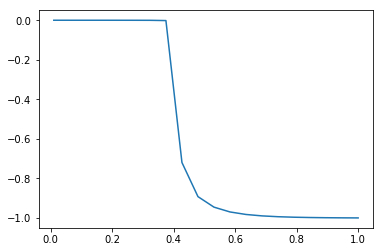

In [24]:
plt.plot(betas,results)
plt.show()

In [16]:
aplus = isingtpf2d(beta,0.000001)
bplus = isings2d(beta,0.000001)
aminus = isingtpf2d(beta,-0.000001)
bminus = isings2d(beta,-0.000001)

print bplus
print bminus

[[[[  7.32108310e+00   4.95400305e-01]
   [  4.95400305e-01   3.39901780e-08]]

  [[  4.95400305e-01   3.39901780e-08]
   [  3.39901780e-08  -4.95399554e-01]]]


 [[[  4.95400305e-01   3.39901780e-08]
   [  3.39901780e-08  -4.95399554e-01]]

  [[  3.39901780e-08  -4.95399554e-01]
   [ -4.95399554e-01  -7.32106839e+00]]]]
[[[[  7.32106839e+00   4.95399554e-01]
   [  4.95399554e-01  -3.39901780e-08]]

  [[  4.95399554e-01  -3.39901780e-08]
   [ -3.39901780e-08  -4.95400305e-01]]]


 [[[  4.95399554e-01  -3.39901780e-08]
   [ -3.39901780e-08  -4.95400305e-01]]

  [[ -3.39901780e-08  -4.95400305e-01]
   [ -4.95400305e-01  -7.32108310e+00]]]]


# h = 0

In [25]:
h = 0
betas = np.linspace(0.01,1,20)
results = []

for beta in betas:
    a = isingtpf2d(beta,h)
    b = isings2d(beta,h)

    for i in range(20):
        b, a = coarse_graining_step(b,a,D=7)
    
    ap = ncon([a,a,a,a],[[7,5,3,1],[3,6,7,2],[8,1,4,5],[4,2,8,6]])
    bp = ncon([b,a,a,a],[[7,5,3,1],[3,6,7,2],[8,1,4,5],[4,2,8,6]])
    
    results.append(bp/ap)

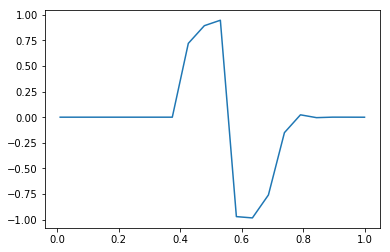

In [26]:
plt.plot(betas,results)
plt.show()

# h positive

In [27]:
h = 0.00000001
betas = np.linspace(0.01,1,20)
results = []

for beta in betas:
    a = isingtpf2d(beta,h)
    b = isings2d(beta,h)

    for i in range(20):
        b, a = coarse_graining_step(b,a,D=7)
    
    ap = ncon([a,a,a,a],[[7,5,3,1],[3,6,7,2],[8,1,4,5],[4,2,8,6]])
    bp = ncon([b,a,a,a],[[7,5,3,1],[3,6,7,2],[8,1,4,5],[4,2,8,6]])
    
    results.append(bp/ap)

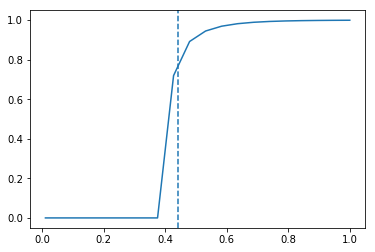

In [28]:
plt.plot(betas,results)
plt.axvline(x=0.44069,linestyle='--')
plt.show()

# -------------------

In [9]:
def isingtpf3d(beta,h):
    H_local = np.array([[-1.-h/2,1.],[1.,-1.+h/2]]) #h is intended to be a small magnetic field to break symmetry
    Q = np.exp(-beta*H_local)
    
    delta = np.zeros((2,2,2,2,2,2))
    delta[0,0,0,0,0,0] = 1.
    delta[1,1,1,1,1,1] = 1.

    Qsr = scl.sqrtm(Q)

    a = ncon([delta,Qsr,Qsr,Qsr,Qsr,Qsr,Qsr],[[1,2,3,4,5,6],[-1,1],[-2,2],[3,-3],[4,-4],[-5,5],[6,-6]])
    
    return a

def isings3d(beta,h):
    H_local = np.array([[-1.-h,1.],[1.,-1.+h]])
    Q = np.exp(-beta*H_local)
    
    g = np.zeros((2,2,2,2,2,2))
    g[0,0,0,0,0,0] = 1.
    g[1,1,1,1,1,1] = -1.

    Qsr = scl.sqrtm(Q)

    b = ncon([g,Qsr,Qsr,Qsr,Qsr,Qsr,Qsr],[[1,2,3,4,5,6],[-1,1],[-2,2],[3,-3],[4,-4],[-5,5],[6,-6]])
    
    return b

In [14]:
def coarse_graining_step_3D(b,a,D='infinity'):
    
    #z direction
    A = ncon([a,a],[[-1,-3,-5,-7,1,-10],[-2,-4,-6,-8,-9,1]])
    Uy, s, V = tensorsvd(A,[6,7],[0,1,2,3,4,5,8,9],D)
    Ux, s, V = tensorsvd(A,[0,1],[2,3,4,5,6,7,8,9],D)
    A = dncon([Ux,Uy,A,Uy,Ux],[[1,2,-1],[7,8,-4],[1,2,3,4,5,6,7,8,-5,-6],[3,4,-2],[5,6,-3]])
    
    B = dncon([b,a],[[-1,-3,-5,-7,1,-10],[-2,-4,-6,-8,-9,1]])    
    B = dncon([Ux,Uy,B,Uy,Ux],[[1,2,-1],[7,8,-4],[1,2,3,4,5,6,7,8,-5,-6],[3,4,-2],[5,6,-3]])
    
    #y direction
    AA = dncon([A,A],[[-1,-2,1,-6,-7,-8],[1,-3,-4,-5,-9,-10]])
    Uz, s, V = tensorsvd(AA,[6,8],[0,1,2,3,4,5,7,9],D)
    Ux, s, V = tensorsvd(AA,[1,2],[0,3,4,5,6,7,8,9],D) 
    AA = dncon([Uz,Ux,AA,Ux,Uz],[[5,7,-5],[1,2,-2],[-1,1,2,-3,3,4,5,6,7,8],[4,3,-4],[6,8,-6]])  
    
    BA = dncon([B,A],[[-1,-2,1,-6,-7,-8],[1,-3,-4,-5,-9,-10]])
    BA = dncon([Uz,Ux,BA,Ux,Uz],[[5,7,-5],[1,2,-2],[-1,1,2,-3,3,4,5,6,7,8],[4,3,-4],[6,8,-6]])
    
    #x direction
    
    AAAA = dncon([AA,AA],[[-2,-3,-4,1,-7,-8],[-1,1,-5,-6,-9,-10]])
    Uz, s, V = tensorsvd(AAAA,[6,8],[0,1,2,3,4,5,7,9],D)
    Uy, s, V = tensorsvd(AAAA,[3,4],[0,1,2,5,6,7,8,9],D)
    AAAA = dncon([Uz,Uy,AAAA,Uy,Uz],[[5,7,-5],[3,4,-3],[1,2,-2,3,4,-4,5,6,7,8],[2,1,-1],[6,8,-6]])
                        
    BAAA = dncon([BA,AA],[[-2,-3,-4,1,-7,-8],[-1,1,-5,-6,-9,-10]])
    BAAA = dncon([Uz,Uy,BAAA,Uy,Uz],[[5,7,-5],[3,4,-3],[1,2,-2,3,4,-4,5,6,7,8],[2,1,-1],[6,8,-6]])
    
    maxAAAA = np.max(AAAA)
    
    BAAA = BAAA/maxAAAA #divides over largest value in the tensor
    AAAA = AAAA/maxAAAA
    
        
    return BAAA, AAAA, s, maxAAAA

In [15]:
a = isingtpf3d(3.0,10**-8)

In [18]:
AAAA, AAAA, s, maxAAAA = coarse_graining_step_3D(a,a)

(16, 16, 16, 16, 16, 16)